#### MPO 762 - Problem Set 4
#### Tiago Carrilho Bilo 
#### C\# 11950866


# The SWE with a background current 

(solved by hand)


# Numerical Experimentation

Model: 2D Inviscid shallow water equations on a non-rotating frame of reference and on a staggered C-grid

$$\frac{\partial u_{i+\frac{1}{2},j}}{\partial t} + \delta_{x} \Phi_{i+\frac{1}{2},j} = 0$$

$$\frac{\partial v_{i,j+\frac{1}{2}}}{\partial t} + \delta_{y} \Phi_{i,j+\frac{1}{2}} = 0$$

$$\frac{\partial \eta_{i,j}}{\partial t} + \delta_{x} U_{i,j} + \delta_{y} V_{i,j} = 0$$

Where: 

* $(\delta_{x},\delta_{y}) =$ centered difference partial derivatives in x and y; 

* $U_{i+\frac{1}{2},j} = \overline{H}^{x}_{i+\frac{1}{2},j} \times u_{i+\frac{1}{2},j}$  mass flux through the x-face of the grid cell;

* $V_{i,j+\frac{1}{2}} = \overline{H}^{y}_{i,j+\frac{1}{2}} \times v_{i,j+\frac{1}{2}}$  mass flux through the y-face of the grid cell;

* $\Phi_{i,j} = g \eta_{i,j}$ (pressure) potential.

The model will be integrated using a RK3 time stepping scheme. 


## Standing wave

Assuming a **CLOSED** rectangular basin with the following initial condition:

$$u(x,y,t=0) = 0$$

$$v(x,y,t=0) = 0$$

$$\eta (x,y,t=0) = \alpha cos(\frac{m \pi x}{a}) cos(\frac{n \pi y}{b})$$

The analytic solution will be: 

$$u(x,y,t) = U sin(\frac{m \pi x}{a}) cos(\frac{n \pi y}{b}) sin(\omega t)$$

$$v(x,y,t) = V cos(\frac{m \pi x}{a}) sin(\frac{n \pi y}{b}) sin(\omega t)$$

$$\eta (x,y,t) = \alpha cos(\frac{m \pi x}{a}) cos(\frac{n \pi y}{b}) cos(\omega t)$$

where $U = \alpha \frac{g}{\omega} \frac{m \pi}{a}$, $V = \alpha \frac{g}{\omega} \frac{n \pi}{a}$, $\omega = c \sqrt{\frac{m^{2} \pi^{2}}{a^{2}}+\frac{n^{2} \pi^{2}}{b^{2}}}$, and $c = \sqrt{gH}$.

In [1]:
% Clear memory and close all figures
clear all 
close all 


% Model parameters
H = 10.0;                         % Cte depth [m]
a = 1280.0;                       % Basin x-dimension [m]
b = 640.0;                        % Basin y-dimension [m]
alpha = 0.1;                      % Wave amplitude [m]

m = 2;                            % Wave zonal mode
n = 1;                            % Wave meridional mode  

g = 10.0;                         % Acceleration due to gravity [m/s2]

mu = 0.5;                         % Courant number
c = sqrt(g*H);                    % Phase speed 

dx = [20,10,5,2];                 % Zonal grid spacing [m]
dt = mu*dx/c;                     % Time step [s] 
dy = dx;                          % Meridional grid spacing [m]

ts = [32,64,128,256];             % Save solutions time-steps [s] 


**Note:** In order to obtain a stable differentiation scheme it is imperative to adjust the Courant number ($\mu = \frac{c \Delta t}{\Delta x}$) accordingly with the C-grid and RK3 stability regions. Setting $\mu = 0.5$ the stability is guaranteed for all experiments.  


In [2]:
% Run the 2D-Inviscid Shallow Water Model
% in a closed rectangular basin described by a C-grid
% 
% The model integration is done by calling isw_2d_cp.m
for i = [1:length(dx)]

    % Grid cells and grid cell edges - Grid set-up
    [x,xe,Nx] = FDGrid(0,a,dx(i)); 
    [y,ye,Ny] = FDGrid(0,b,dy(i));

    [x_eta,y_eta] = meshgrid(x,y);      % eta,H grid points
    [x_u,y_u] = meshgrid(xe,y);         % u,U   grid points
    [x_v,y_v] = meshgrid(x,ye);         % v,V   grid points
    [xe,ye] = meshgrid(xe,ye);          % vorticiy grid points
    
    
    % Printing some Grid information
    disp(' ')    
    disp(' ')
    disp(['[outputs ',num2str(i),']'])
    disp(['Resolution:      ',num2str(dx(i)),' m'])
    disp(['Number of x-cells: ',num2str(Nx)])
    disp(['Number of y-cells: ',num2str(Ny)])    
    disp(' ')


    % Initial condition
    u0 = zeros(size(x_u));
    v0 = zeros(size(x_v));
    eta0 = alpha.*cos(m*pi*x_eta/a).*cos(n*pi*y_eta/b);


    % Integration
    [volume,energy,u,v,eta] = ...
        isw_2d_cb(dx(i),dy(i),a,b,H,g,dt(i),ts,u0,v0,eta0);


    %% Computing the rms error with respect to the analytical solution
    % Analytical solution
    omega = c*sqrt((m*m*pi*pi/(a*a))+(n*n*pi*pi/(b*b)));  % frequency 
    
    Au = alpha*g*m*pi/(omega*a);                    % Amplitude of u
    Av = alpha*g*n*pi/(omega*b);                    % Amplitude of v
    
    for j = [1:length(ts)]
        ua = Au.*sin(m*pi*x_u/a).*cos(n*pi*y_u/b).*sin(omega*ts(j));
        va = Av.*cos(m*pi*x_v/a).*sin(n*pi*y_v/b).*sin(omega*ts(j));
        etaa = alpha.*cos(m*pi*x_eta/a).*cos(n*pi*y_eta/b) ...
            .*cos(omega*ts(j));
        
        % RMS errors 
        erms(1,i,j) = sqrt(sum(sum((ua-u(:,:,j)).^2))/2)*dx(i)/a;
        erms(2,i,j) = sqrt(sum(sum((va-v(:,:,j)).^2))/2)*dx(i)/a;
        erms(3,i,j) = 100*sqrt(sum(sum((etaa-eta(:,:,j)).^2))/2)*dx(i)/a;        
        
    end

    % Reporting results
    disp('_________________________________________________')
    disp(['Time step (s):           ',num2str(ts)])
    disp('_________________________________________________')
    disp(['Volume displacement (m^3/s):   ',num2str(volume)])    
    disp(['Total energy (kJ/density unit): ',num2str(energy/1000)])
    disp(' ')
end

[outputs 1]
Resolution:      20 m
Number of x-cells: 64
Number of y-cells: 32
 
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Volume displacement (m^3/s):   6.5659e-13 -4.2241e-14   7.043e-14 -2.5535e-13
Total energy (kJ/density unit): 10.2237      10.2159      10.2309      10.2157
 
 
 
[outputs 2]
Resolution:      10 m
Number of x-cells: 128
Number of y-cells: 64
 
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Volume displacement (m^3/s):   -2.7777e-13 -1.9276e-13  -4.208e-13 -8.8458e-13
Total energy (kJ/density unit): 10.236      10.2341      10.2381      10.2346
 
 
 
[outputs 3]
Resolution:      5 m
Number of x-cells: 256
Number of y-cells: 128
 
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Vol

### Conservation of energy and volume: 

From the outputs shown above, it is possible to verify that the closed boundaries and the conservation of volume law (i. e., continuity equation) guarantee the approximately constant values of volume displacement and total mechanical energy in the system. Note that the volume displament values are extremely small $O(10^{-12}-10^{-14})$ m$^{3}$ s$^{-1}$ and vary around absolute 0.0. Additionaly, the energy is kept approximately 10.23 kJ per density unit.

### Accuracy of the spatial discretization: 

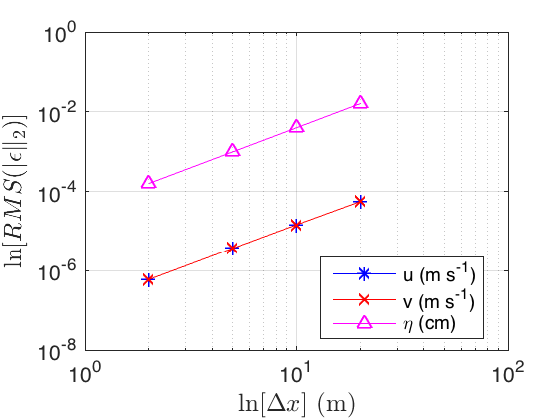

[outputs 5]
Slope: 1.9708


In [3]:
%% Verify if the scheme is second order accurate in space
[slope,lnA] = polyfit(log(dx), log(erms(1,:,end)), 1);

disp('[outputs 5]')
disp(['Slope: ', num2str(slope(1))])

%% Truncation error diagrams
loglog(dx,erms(1,:,end),'*-','color','b')
hold on
loglog(dx,erms(2,:,end),'x-','color','r')
loglog(dx,erms(3,:,end),'^-','color','m')

grid on

xlabel('ln[$\Delta x$] (m)','Interpret','latex','FontSize',12); 
ylabel('ln[$RMS(|\epsilon\| _2)]$','Interpret','latex','FontSize',12);

legend('u (m s^{-1})','v (m s^{-1})','\eta (cm)','Location','Best')

**Figure 1.** Truncation error diagrams for the SWE variables at the final time step of integration. All curves are linear in the logarithmic scale and parallel with respect to each other with a slope of approximately 1.

As mentioned before, the equations were discretized in a C-grid. Therefore $|\epsilon|$ is proportional to $O(A \Delta x^{2} + B \Delta y^{2} + C \Delta t^{3} + higher\ order\ terms)$, where A, B and C are related to the derivatives o the variables. Therefore, if $\Delta t$ is kept the same in all experiments the slope of the curves above (i. e., $ln(|\epsilon|) = Slope \times ln(\Delta x)$) is expected to be approximately 2. 

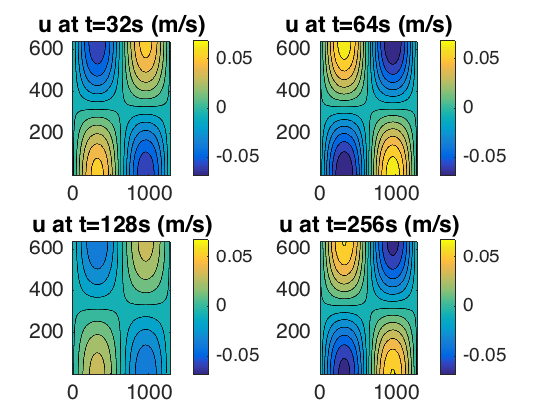

In [4]:
% u 
for i = [1:length(ts)]
    subplot(2,2,i)
    contourf(x_u,y_u,u(:,:,i),...
        [min(min(min(u))):0.01:max(max(max(u)))]);
    title(['u at t=',num2str(ts(i)),'s (m/s)']);
    colorbar
    caxis([min(min(min(u))),max(max(max(u)))]);    
end

**Figure 2.** Numeircal solutions of u for $(\Delta x,\Delta y) = 2$ m.

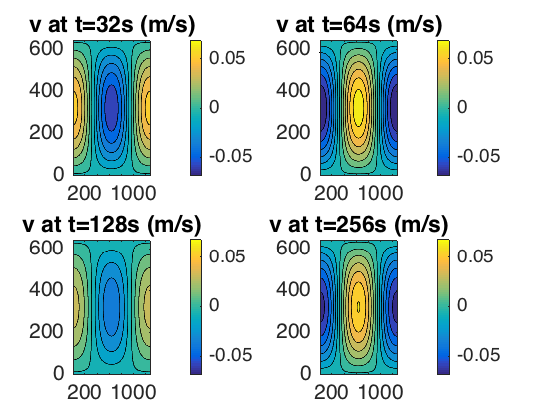

In [5]:
% v 
for i = [1:length(ts)]
    subplot(2,2,i)
    contourf(x_v,y_v,v(:,:,i),...
        [min(min(min(v))):0.01:max(max(max(v)))]);
    title(['v at t=',num2str(ts(i)),'s (m/s)']);
    colorbar
    caxis([min(min(min(v))),max(max(max(v)))]);   
end

**Figure 3.** Numeircal solutions of v for $(\Delta x,\Delta y) = 2$ m.

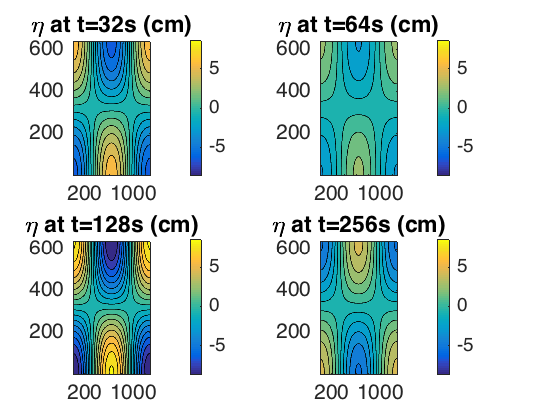

In [6]:
% eta 
for i = [1:length(ts)]
    subplot(2,2,i)
    contourf(x_eta,y_eta,100*eta(:,:,i),... 
        [min(min(min(100*eta))):1:max(max(max(100*eta)))]);
    title(['\eta at t=',num2str(ts(i)),'s (cm)']);
    colorbar
    caxis([min(min(min(100*eta))),max(max(max(100*eta)))]);
end

**Figure 4.** Numeircal solutions of $\eta$ for $(\Delta x,\Delta y) = 2$ m.

## Wave propagation

Assuming a **CLOSED** rectangular basin with the following initial condition:

$$u(x,y,t=0) = 0$$

$$v(x,y,t=0) = 0$$

$$\eta (x,y,t=0) = \alpha e^{-\frac{-r^{2}}{l^{2}}}$$

$$r^{2}(x,y) = (\frac{a}{2}-x)^{2} + (\frac{b}{2}-y)^{2}$$

where $r$ is the radial distance from the center of the basin and $l$ is the wave height decay scale. The numerical solutions for $(\Delta x, \Delta y) = 8,\ 4,\ 2$ m will be the following:

In [7]:
% Clear memory and close all figures
clear all 
close all 


% Model parameters
H1 = 10.0;                        % Cte depth [m]
a = 1280.0;                       % Basin x-dimension [m]
b = 640.0;                        % Basin y-dimension [m]
alpha = 0.1;                      % Wave amplitude [m]
l2 = 25.0*25.0;                   % Wave height decay scale [m2]

g = 10;                           % Acceleration due to gravity [m/s2]

dt = 0.1;                         % Time step [s]                     
dx = [8,4,2];                     % Zonal grid spacing [m]
dy = dx;                          % Meridional grid spacing [m]

ts = [32,64,128,256];             % Save solutions time-steps [s] 

**Extra experiment:** In order to verify how a propagating wave would be affected by a variable topography we ran a second experiment where

$$H(x) = 10 + 5 tanh(\frac{x-100}{16})$$

In [8]:
% Run the 2D-Inviscid Shallow Water Model
% in a closed rectangular basin described by a C-grid
% 
% The model integration is done by calling isw_2d_cp.m
for i = [1:length(dx)]

    % Grid cells and grid cell edges - Grid set-up
    [x,xe,Nx] = FDGrid(0,a,dx(i)); 
    [y,ye,Ny] = FDGrid(0,b,dy(i));

    [x_eta,y_eta] = meshgrid(x,y);      % eta,H grid points
    [x_u,y_u] = meshgrid(xe,y);         % u,U   grid points
    [x_v,y_v] = meshgrid(x,ye);         % v,V   grid points
    [xe,ye] = meshgrid(xe,ye);          % vorticiy grid points
    
    
    % Variable topography
    H2 = 10.0+5.0*tanh((x_eta-100.0)/16.0);
    
    % Square of the radial distance from the center of the basin
    r2 = (((a/2)-x_eta).^2)+(((b/2)-y_eta).^2);
     
    % Printing some Grid information
    disp(' ')    
    disp(' ')
    disp(['[outputs ',num2str(i),']'])
    disp(['Resolution:      ',num2str(dx(i)),' m'])
    disp(['Number of x-cells: ',num2str(Nx)])
    disp(['Number of y-cells: ',num2str(Ny)])    
    disp(' ')


    % Initial condition
    u0 = zeros(size(x_u));
    v0 = zeros(size(x_v));
    eta0 = alpha.*exp(-r2/l2);


    %% Integration
    % Constant depth
    [volume1,energy1,u1,v1,eta1] = ...
        isw_2d_cb(dx(i),dy(i),a,b,H1,g,dt,ts,u0,v0,eta0);


    [volume2,energy2,u2,v2,eta2] = ...
        isw_2d_cb(dx(i),dy(i),a,b,H2,g,dt,ts,u0,v0,eta0);


    % Reporting results
    disp('Constant Depth H1 = 10 m')
    disp('_________________________________________________')
    disp(['Time step (s):           ',num2str(ts)])
    disp('_________________________________________________')
    disp(['Volume displacement (m^3/s):   ',num2str(volume1)])    
    disp(['Total energy (J/density unit): ',num2str(energy1)])
    disp(' ')
    
    disp('Variable Depth H2')
    disp('_________________________________________________')
    disp(['Time step (s):           ',num2str(ts)])
    disp('_________________________________________________')
    disp(['Volume displacement (m^3/s):   ',num2str(volume2)])    
    disp(['Total energy (J/density unit): ',num2str(energy2)])
    disp(' ')   
    
end

[outputs 1]
Resolution:      8 m
Number of x-cells: 160
Number of y-cells: 80
 
Constant Depth H1 = 10 m
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Volume displacement (m^3/s):   196.3495      196.3495      196.3495      196.3495
Total energy (J/density unit): 48.2602      48.2375      48.1168      48.0194
 
Variable Depth H2
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Volume displacement (m^3/s):   196.3495      196.3495      196.3495      196.3495
Total energy (J/density unit): 48.1242      47.5189       47.888      47.6564
 
 
 
[outputs 2]
Resolution:      4 m
Number of x-cells: 320
Number of y-cells: 160
 
Constant Depth H1 = 10 m
_________________________________________________
Time step (s):           32   64  128  256
_________________________________________________
Volume displac

### Conservation of volume and energy 

As expected, in both experiments the volume displaced and total mechanical energy are conserved around $\sim 196$ m$^{3}$ s$^{-1}$ and $\sim 48$ J respectively. The volume and energy variations (i. e., trend to decay with time) at different times are similar in every experiment and small.  

### Initial conditions, topography (H2) and solutions for $\eta$

* Initial conditions:

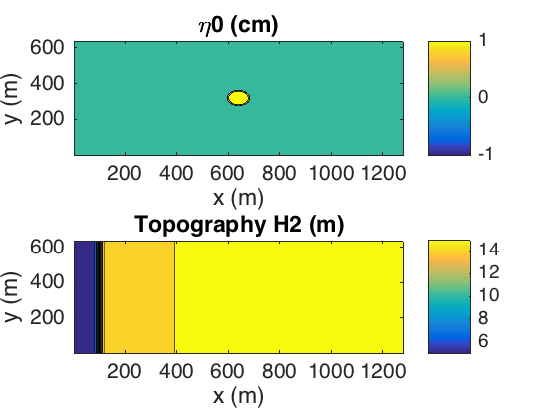

In [9]:
% Initial conditions and H2:
subplot(2,1,1)
contourf(x_eta(1,:),y_eta(:,1),...
    100*eta0,[-1:0.5:1]);
colorbar;
caxis([-1,1]);
title('\eta0 (cm)')
xlabel('x (m)')
ylabel('y (m)')

subplot(2,1,2)
contourf(x_eta(1,:),y_eta(:,1),H2);
colorbar;
title('Topography H2 (m)')
xlabel('x (m)')
ylabel('y (m)')

**Figure 5.** Initial condition for $\eta$ and the local depth H2 used in the extra numerical experiment.   

* $\eta$ for constant depth basin ($H =$ 10 m)

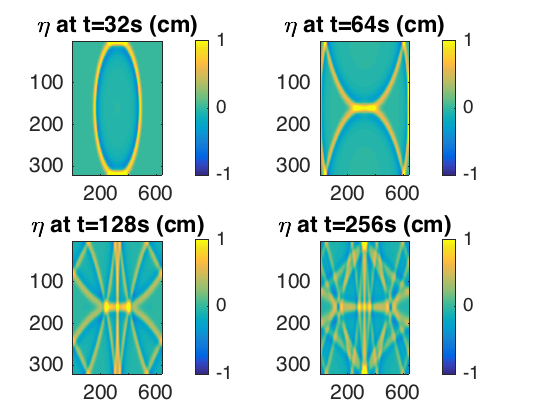

In [10]:
% eta for H1
for i = [1:length(ts)]
    subplot(2,2,i)
    imagesc(100*eta1(:,:,i),... 
        [-1,1]);

    title(['\eta at t=',num2str(ts(i)),'s (cm)']);
    colorbar
    caxis([-1,1]);
end

**Figure 6.** Solutions for $\eta$ in a constant depth basin ($H = $10 m). Note that the solutions are meridionally and zonally symmetric.

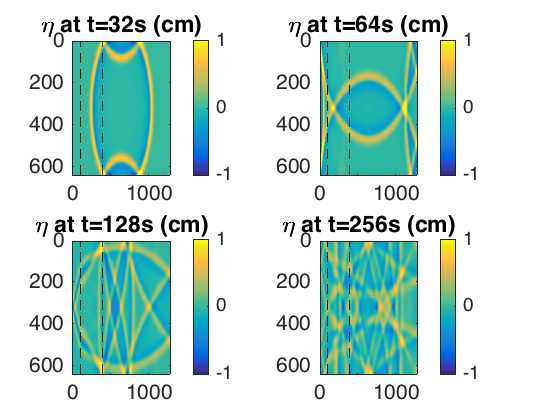

In [11]:
% eta for H2
for i = [1:length(ts)]
    subplot(2,2,i)
    imagesc(x_eta(1,:),y_eta(:,1),100*eta2(:,:,i),... 
        [-1,1]);

     hold on 
     contour(x_eta,y_eta,H2,[10 15],'k--')

    title(['\eta at t=',num2str(ts(i)),'s (cm)']);
    colorbar
    caxis([-1,1]);
end

**Figure 7.** Solutions for $\eta$ in a basin with topography described by H2. The dashed lines correspond to the 10 and 15 m isobaths. Note that the solutions are not zonally simetric anymore. The topography imposes refraction to the waves (i. e., changes in phase valocity $c$) that creates the asymmetry. 